In [1]:
import numpy as np
import pandas as pd
import nmp_util
import matplotlib.pyplot as plt
from astropy.time import Time
import seaborn as sns
sns.set_theme()

,mjd
0,54101.0


,dmjd,R_lin,S_lin,W_lin,R_ang,S_ang,W_ang,date
0,0.000000,0.000011,0.000048,-0.000003,0.301015,-0.329681,-0.039378,2007-01-01 00:00:00
1,0.000012,0.000011,0.000048,-0.000003,0.301055,-0.329769,-0.039365,2007-01-01 00:00:01
2,0.000023,0.000011,0.000048,-0.000003,0.301034,-0.329567,-0.039391,2007-01-01 00:00:02
3,0.000035,0.000011,0.000048,-0.000003,0.301044,-0.329789,-0.039386,2007-01-01 00:00:03
4,0.000046,0.000011,0.000048,-0.000003,0.301064,-0.329831,-0.039393,2007-01-01 00:00:04
...,...,...,...,...,...,...,...,...
86394,0.999931,0.000011,0.000007,-0.000012,0.301017,-0.329934,-0.039382,2007-01-01 23:59:54
86395,0.999942,0.000011,0.000007,-0.000012,0.300989,-0.329819,-0.039438,2007-01-01 23:59:55
86396,0.999954,0.000011,0.000007,-0.000012,0.300978,-0.329556,-0.039427,2007-01-01 23:59:56
86397,0.999965,0.000011,0.000007,-0.000012,0.300958,-0.329908,-0.039864,2007-01-01 23:59:57


<Axes: xlabel='date'>

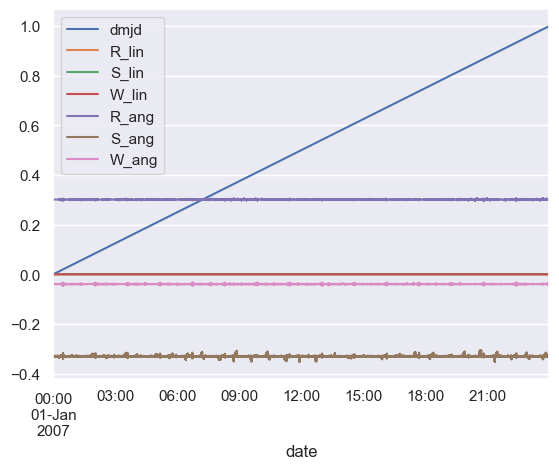

In [2]:
mjd = pd.read_csv('GRCAT07001ACC.sec', delimiter = r'\s+', names = ['mjd'], skiprows = 8, nrows=1)
data_cols = ['R_lin','S_lin','W_lin','R_ang','S_ang','W_ang']
data = pd.read_csv('GRCAT07001ACC.sec', delimiter = r'\s+', names = ['dmjd']+data_cols, skiprows = 9)
display(mjd)

date = Time(mjd['mjd'][0],data['dmjd'], format='mjd', scale='utc').to_datetime()
data['date'] = date
display(data)
data.plot(x='date')

In [3]:
# sample every 10th entry
data_sample = data.loc[::10]
display(data_sample)

,dmjd,R_lin,S_lin,W_lin,R_ang,S_ang,W_ang,date
0,0.000000,0.000011,0.000048,-0.000003,0.301015,-0.329681,-0.039378,2007-01-01 00:00:00
10,0.000116,0.000011,0.000048,-0.000003,0.301072,-0.329640,-0.039245,2007-01-01 00:00:10
20,0.000231,0.000012,0.000048,-0.000002,0.301110,-0.329943,-0.039259,2007-01-01 00:00:20
30,0.000347,0.000012,0.000049,-0.000002,0.301066,-0.329852,-0.039352,2007-01-01 00:00:30
40,0.000463,0.000013,0.000049,-0.000003,0.301104,-0.329926,-0.039395,2007-01-01 00:00:40
...,...,...,...,...,...,...,...,...
86350,0.999421,0.000011,0.000006,-0.000013,0.300987,-0.329930,-0.039264,2007-01-01 23:59:10
86360,0.999537,0.000011,0.000006,-0.000013,0.300949,-0.329516,-0.039304,2007-01-01 23:59:20
86370,0.999653,0.000011,0.000006,-0.000012,0.300992,-0.330410,-0.039557,2007-01-01 23:59:30
86380,0.999769,0.000012,0.000007,-0.000012,0.300986,-0.329946,-0.039606,2007-01-01 23:59:40


In [4]:
def analize_data(date, original, window, interpolate_edge):
    date = date.to_numpy()
    
    cropped = original[window// 2:-window // 2+1] if not interpolate_edge else original
    cropped_date = date[window // 2:-window // 2+1] if not interpolate_edge else date
    def plot_amplitudes(data,label, d = 10, min_freq = 1/(60*30), exponent = 1):
        freq, amplitude = nmp_util.amplitude_spectrum_via_numpy(data, d = d)
        mask = freq >= min_freq
        plt.scatter(freq[mask]*60, amplitude[mask]**exponent, label=label, s=1)

    for i in range(3):
        # Low-pass filter
        l = nmp_util.savitzki_golay_filter(original, deg = i, window = window, interpolate_edge=interpolate_edge)

        h = cropped - l


        plt.figure(figsize=(10, 5))
        plt.scatter(date, original, label=f'Original', s=1)
        plt.scatter(cropped_date, h, label=f'High-pass q={i}', s=1)
        plt.scatter(cropped_date, l, label=f'Low-pass q={i}', s=1)
        plt.xlabel('Date')
        plt.ylabel('Acceleration [m/s$^2$]')
        plt.legend()
        plt.show()
        
        # create zoom for one hour (360 entries)
        plt.figure(figsize=(10, 5))
        plt.scatter(date[:360], original[:360], label=f'Original', s=1)
        plt.scatter(cropped_date[:360], h[:360], label=f'High-pass q={i}', s=1)
        plt.scatter(cropped_date[:360], l[:360], label=f'Low-pass q={i}', s=1)
        plt.xlabel('Date')
        plt.xlabel('Date')
        plt.ylabel('Acceleration [m/s$^2$]')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 5))
        plot_amplitudes(original, 'Original')
        plot_amplitudes(l, f'Low-pass q={i}')
        plot_amplitudes(h, f'High-pass q={i}')
        plt.xlabel('Frequency [1/min]')
        plt.ylabel('Amplitude [m/s$^2$]')
        plt.yscale('log')
        plt.legend()
        plt.show()


# Note:
the filters for q=0 and q=1 are equivalent, but only because i evaluate at x=0, and the data points are equidistant!

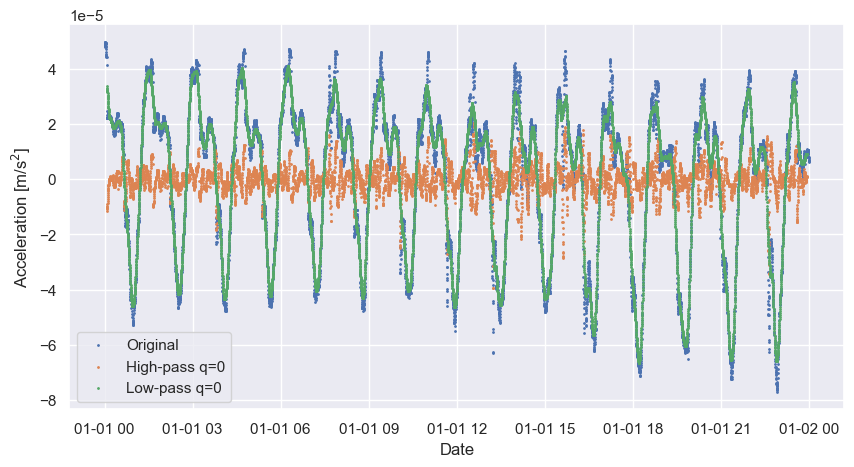

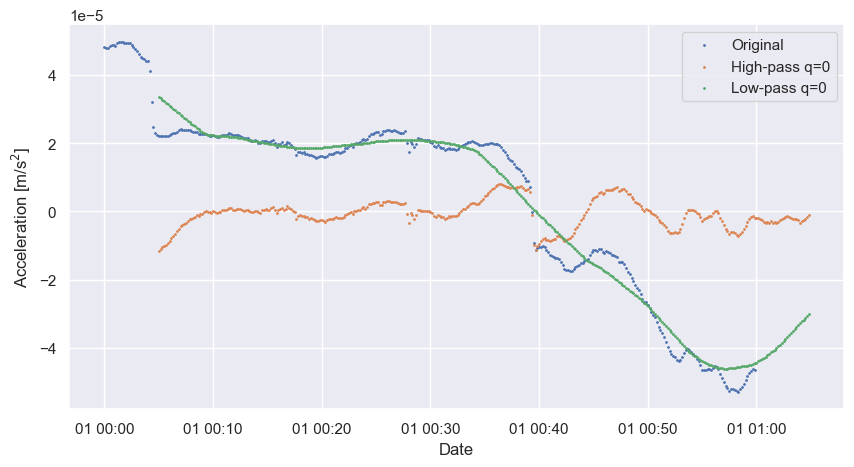

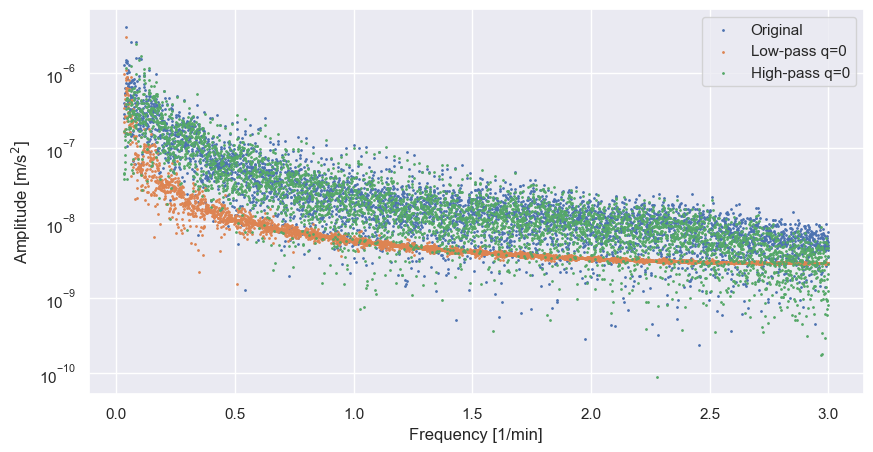

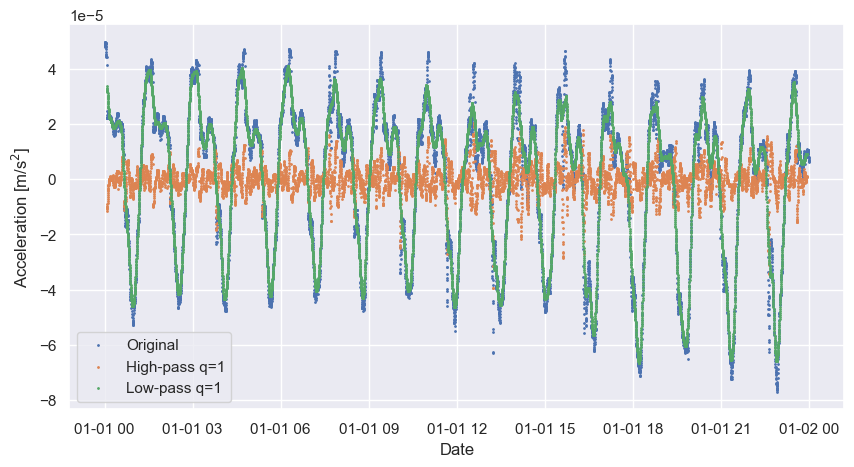

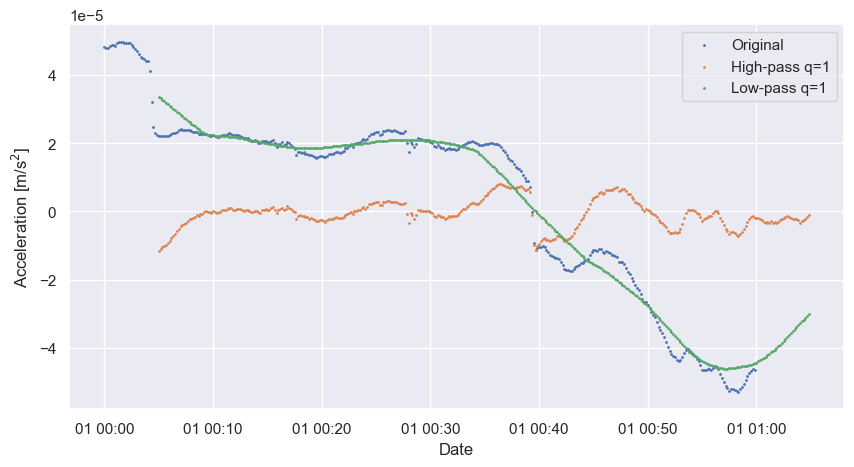

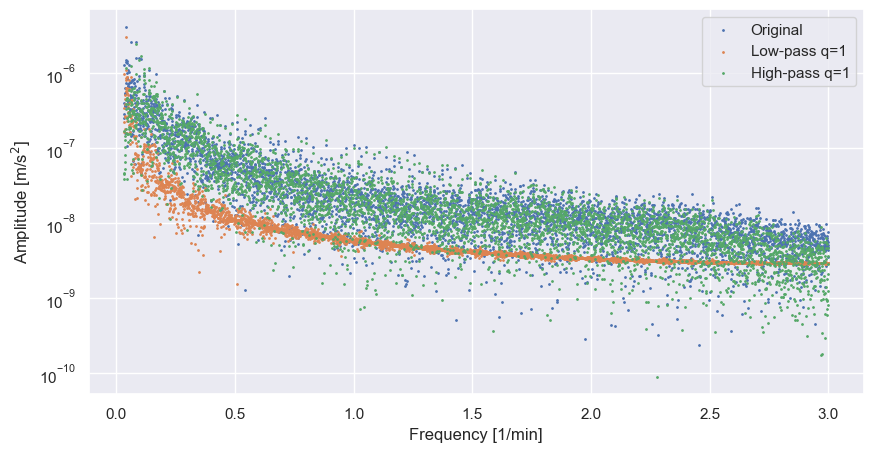

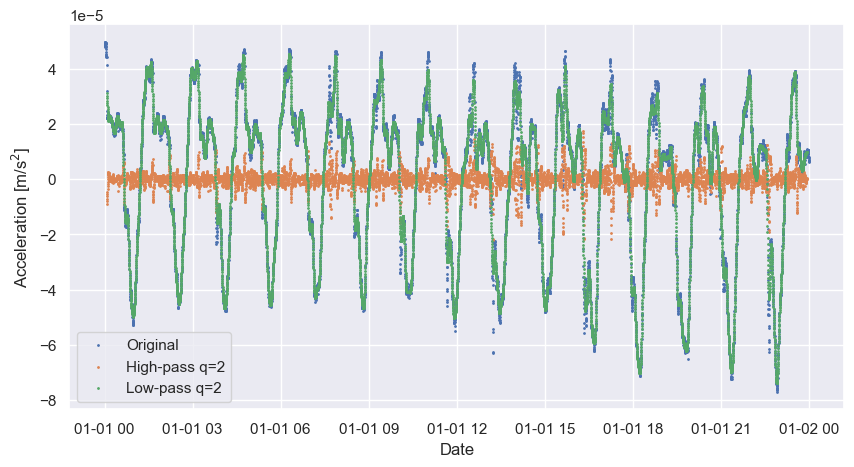

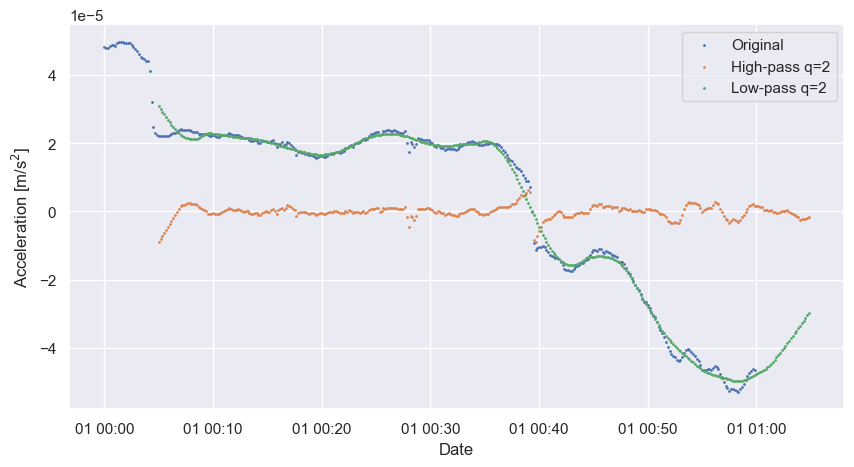

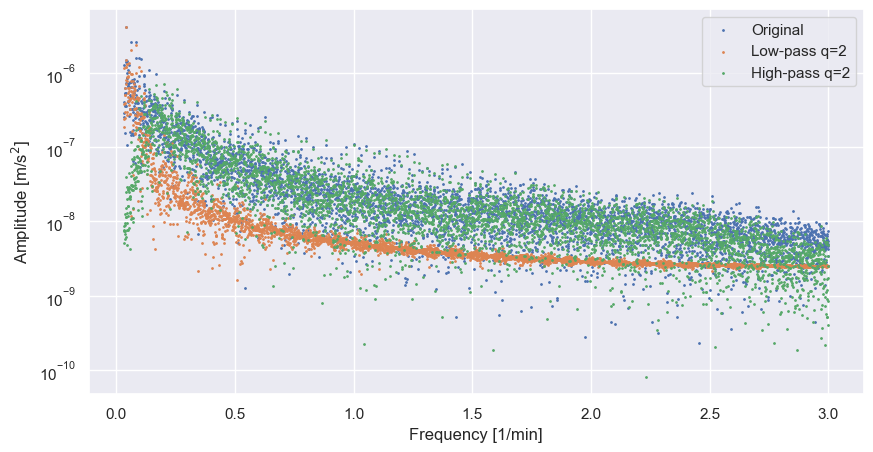

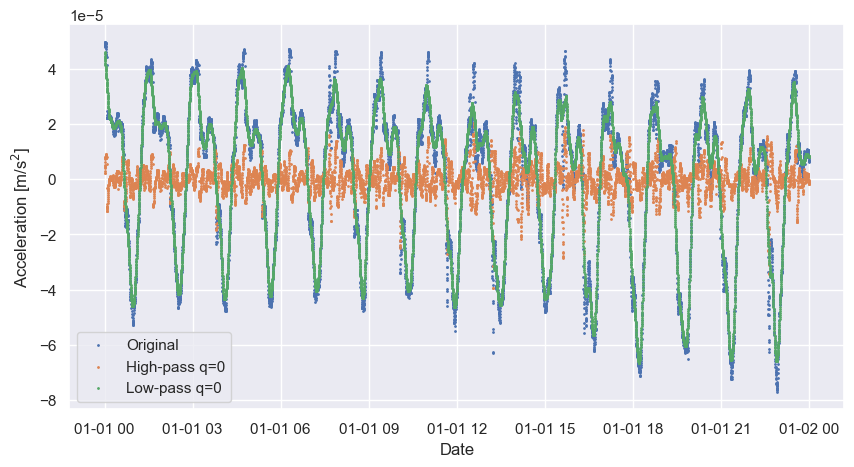

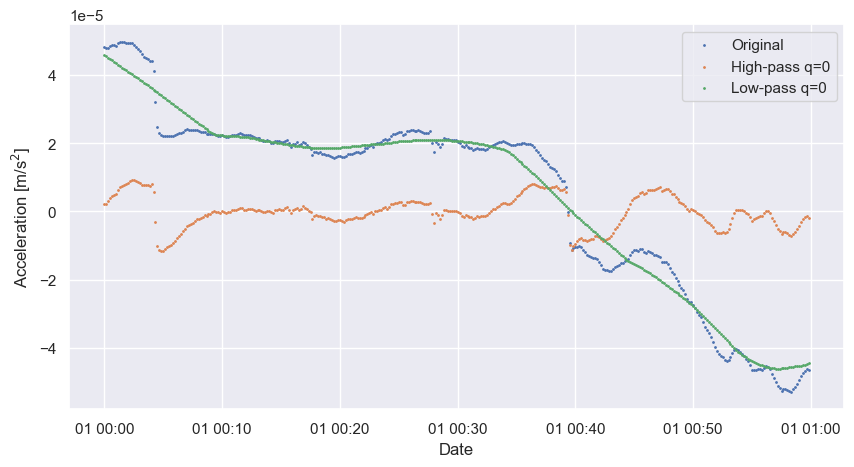

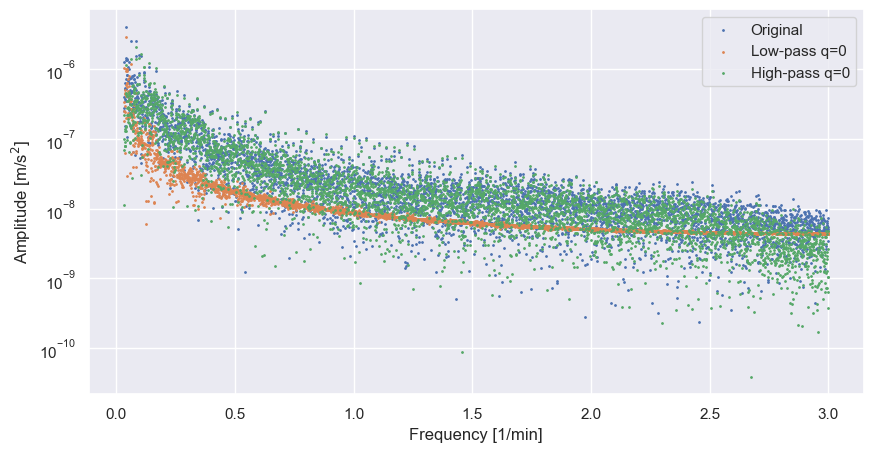

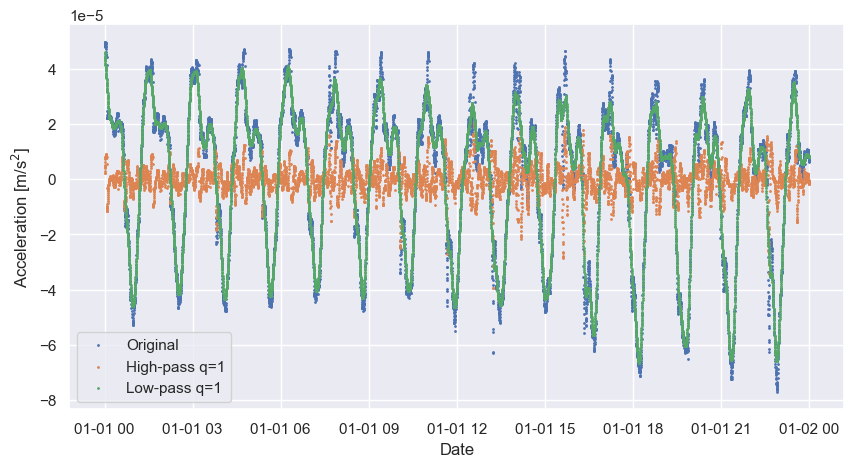

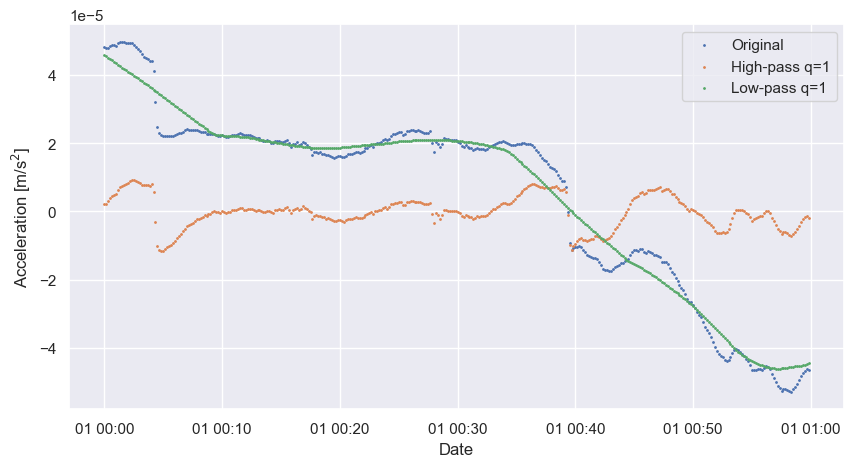

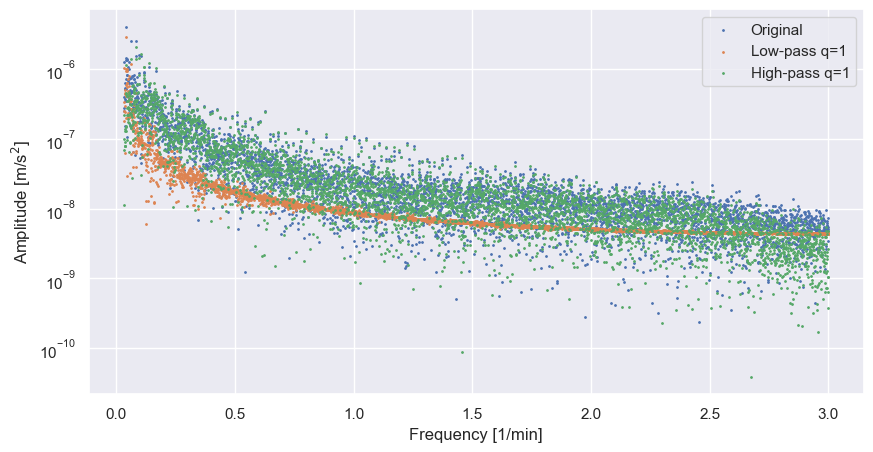

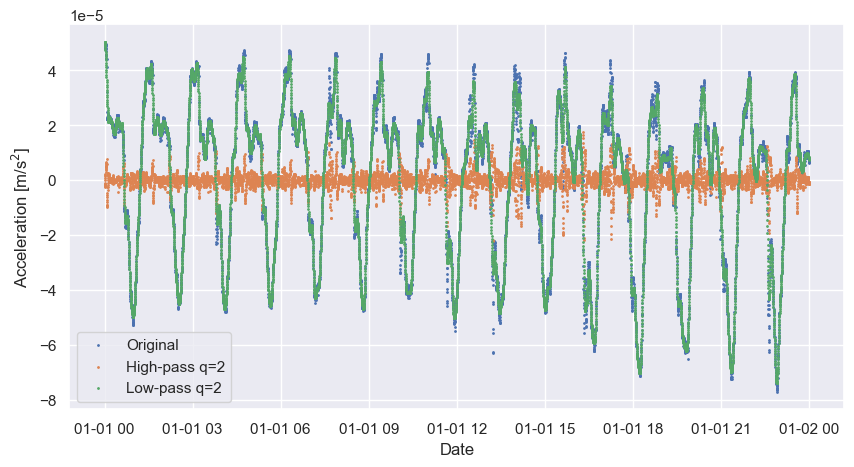

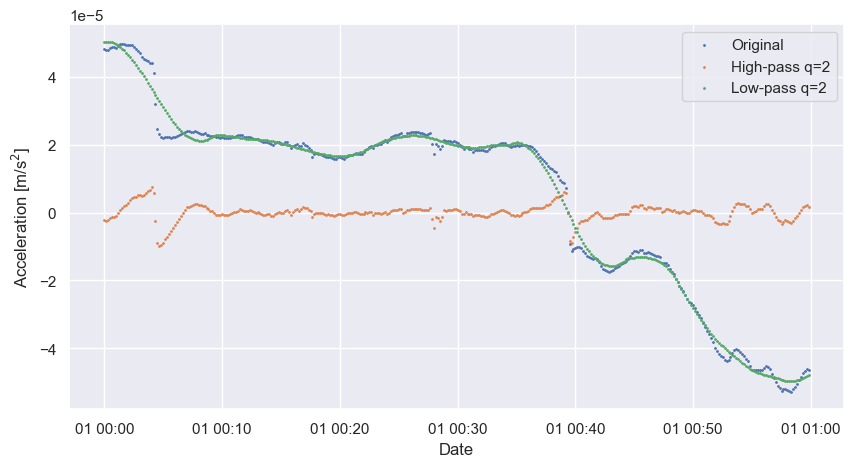

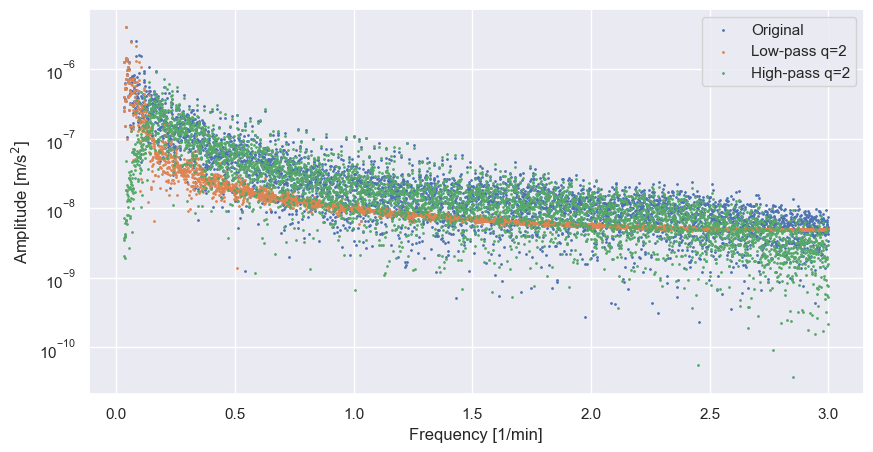

In [ ]:
analize_data(data_sample['date'], data_sample['S_lin'], window = 61, interpolate_edge = False)

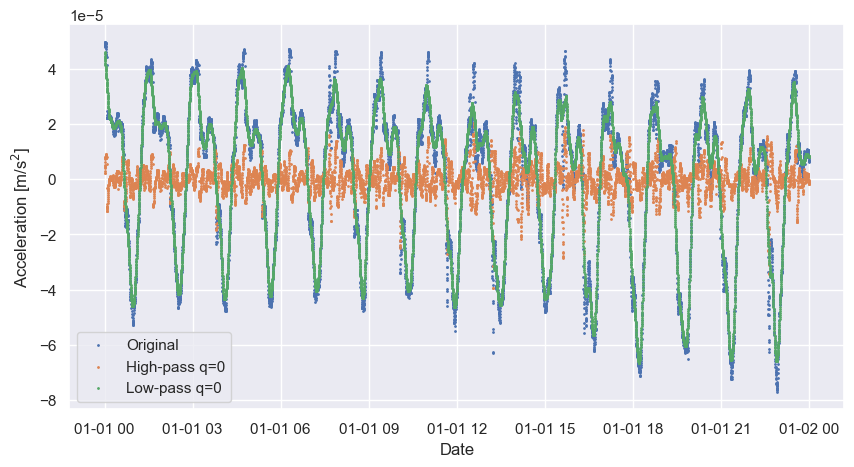

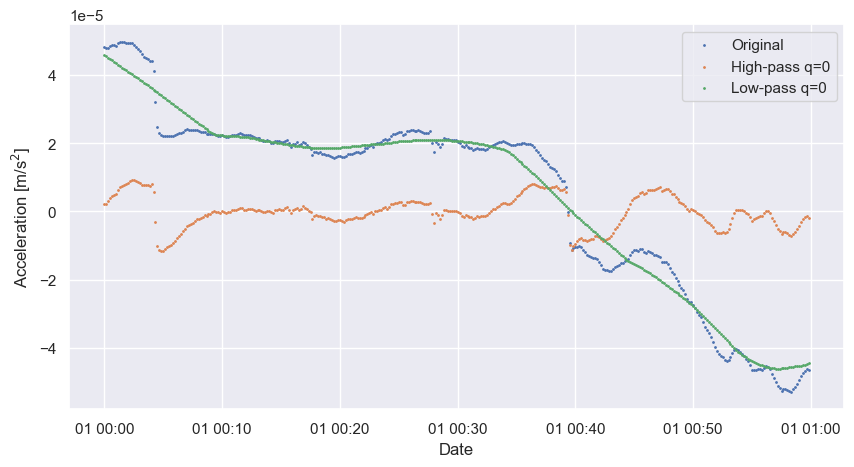

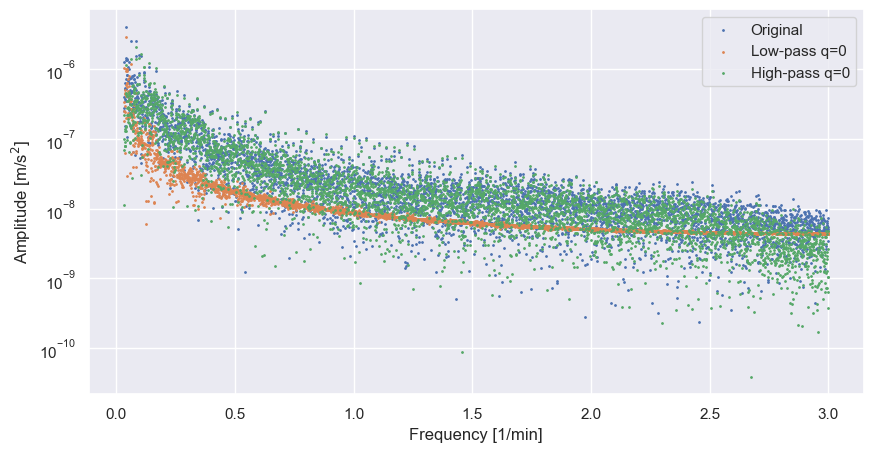

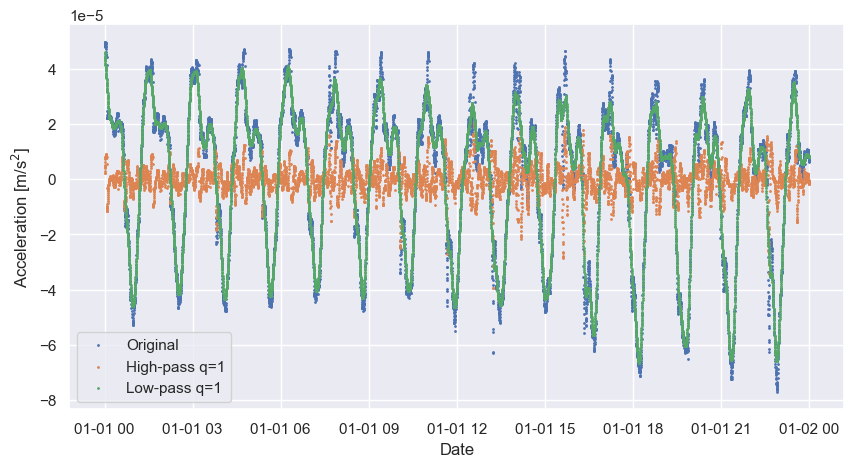

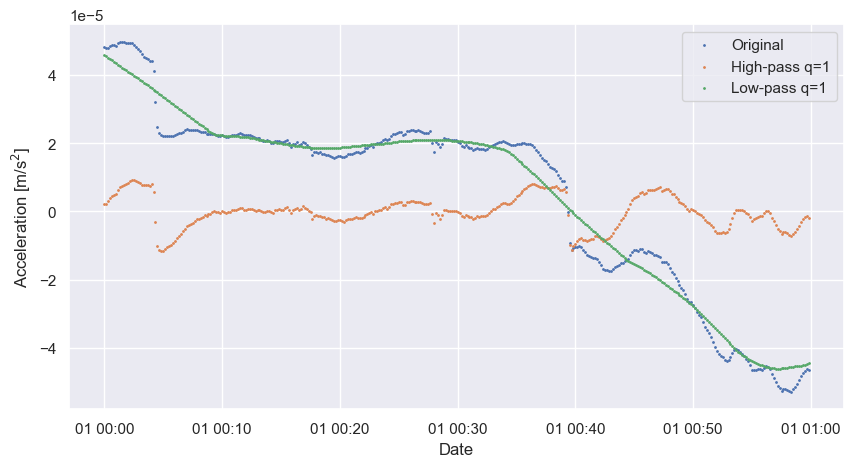

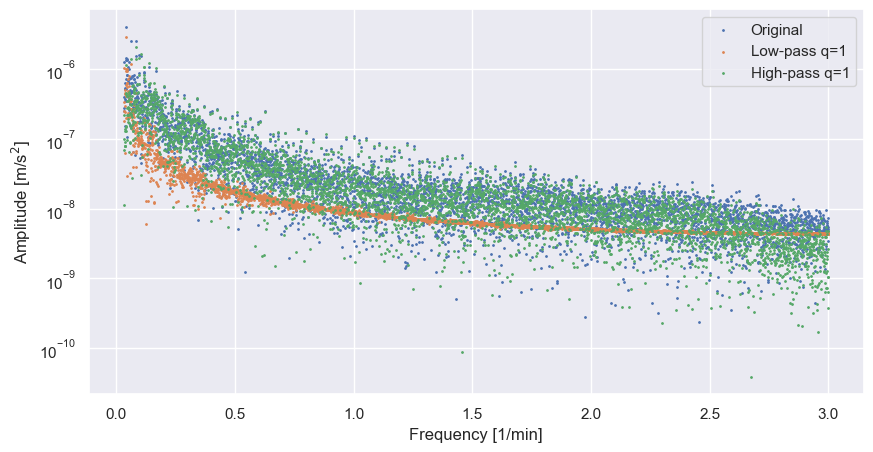

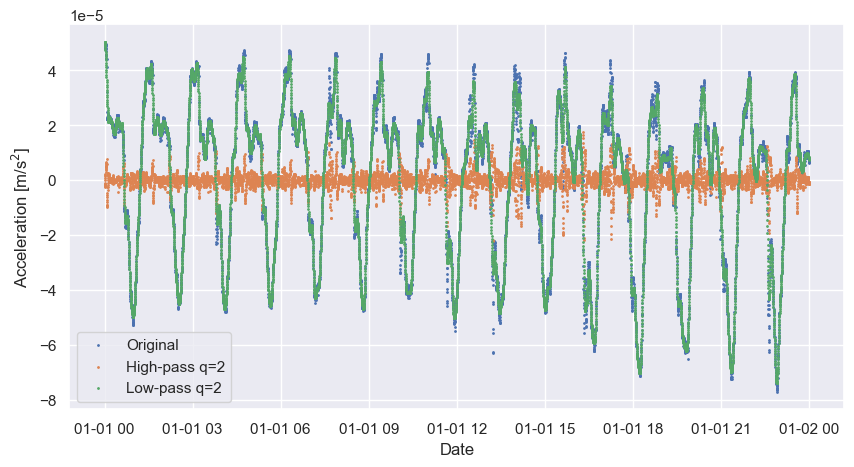

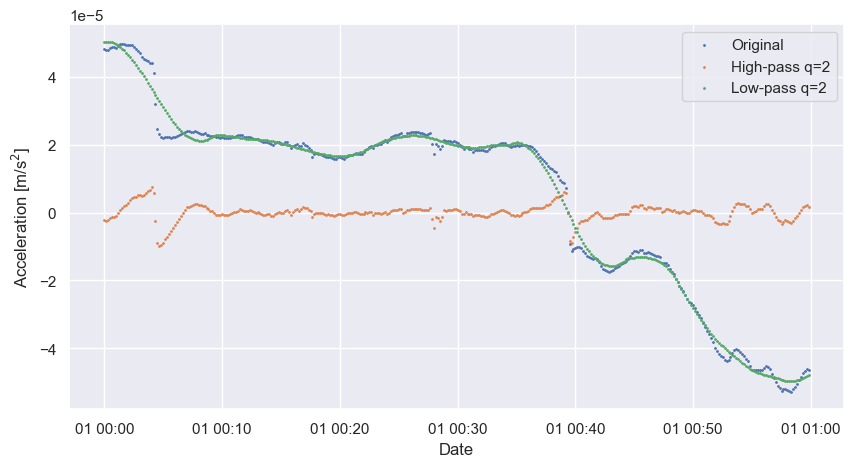

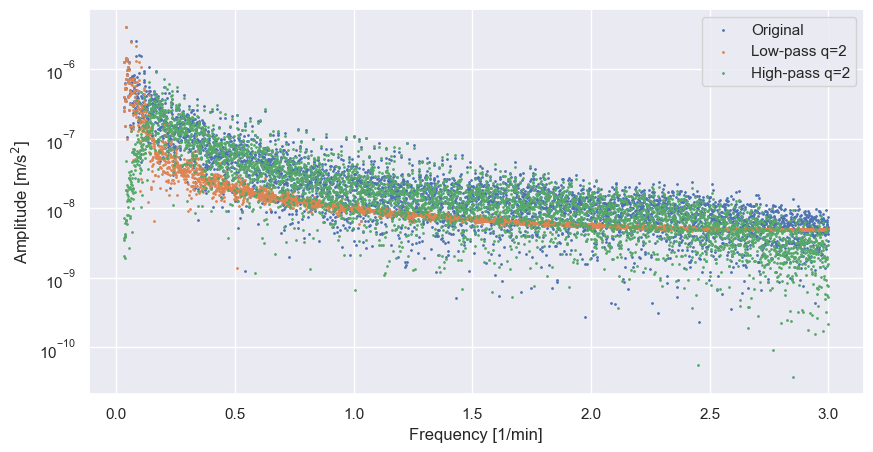

In [8]:
analize_data(data_sample['date'], data_sample['S_lin'], window = 61, interpolate_edge = True)

In [6]:
def fourier_analize(date, data, m):
    dt = (date.iloc[1] - date.iloc[0]).total_seconds() / 60 # in minutes
    coeffs = nmp_util.discrete_fourier_transform(data, m)

    amplitudes = nmp_util.coeffs_to_amplitude(coeffs)
    freqs, amplitudes_np = nmp_util.amplitude_spectrum_via_numpy(data, m, d=dt)
    
    m_max = np.argmax(amplitudes)

    print(f'max coeff: {m_max}, $a_{{mm_max}} = {coeffs[m_max]}, b_{{mm_max}} = {coeffs[m_max+m+1]}$ amplitude = {amplitudes[m_max]}')
    plt.figure(figsize=(10, 5))
    plt.scatter(freqs, amplitudes, label='Amplitudes',s=10, marker='x')
    plt.scatter(freqs, amplitudes_np, label='Amplitudes numpy',s=5)
    plt.xlabel('frequency [1/min]')
    plt.ylabel('amplitude [mm$^2$/s]')
    plt.legend()
    plt.show()


max coeff: 15, $a_{mm_max} = 2.218015369696078e-05, b_{mm_max} = 6.1272708195706324e-06$ amplitude = 2.7092425415787457e-05


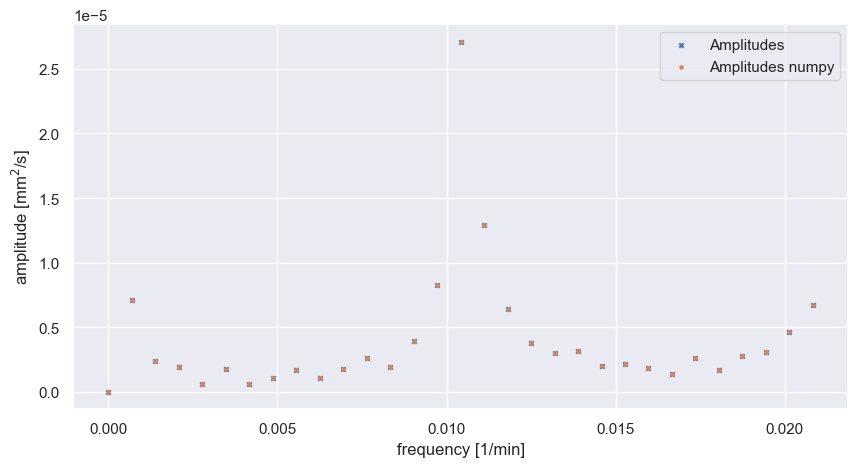

max coeff: 15, $a_{mm_max} = 2.218015369696078e-05, b_{mm_max} = 6.1272708195706375e-06$ amplitude = 2.7092425415787454e-05


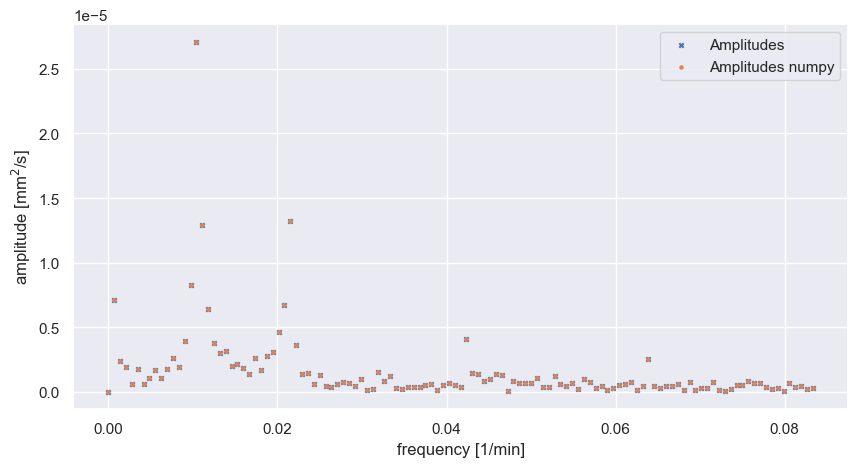

max coeff: 15, $a_{mm_max} = 2.2180153696960776e-05, b_{mm_max} = 6.1272708195706375e-06$ amplitude = 2.7092425415787457e-05


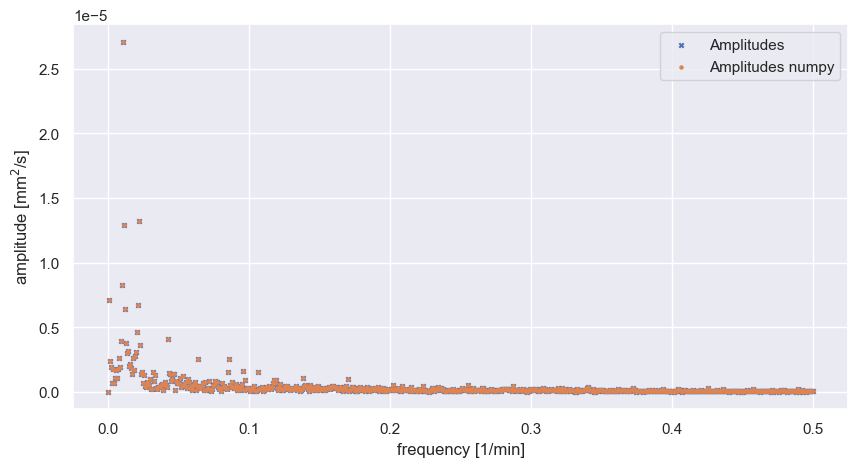

max coeff: 15, $a_{mm_max} = 2.2180153696960786e-05, b_{mm_max} = 6.127270819570631e-06$ amplitude = 2.709242541578747e-05


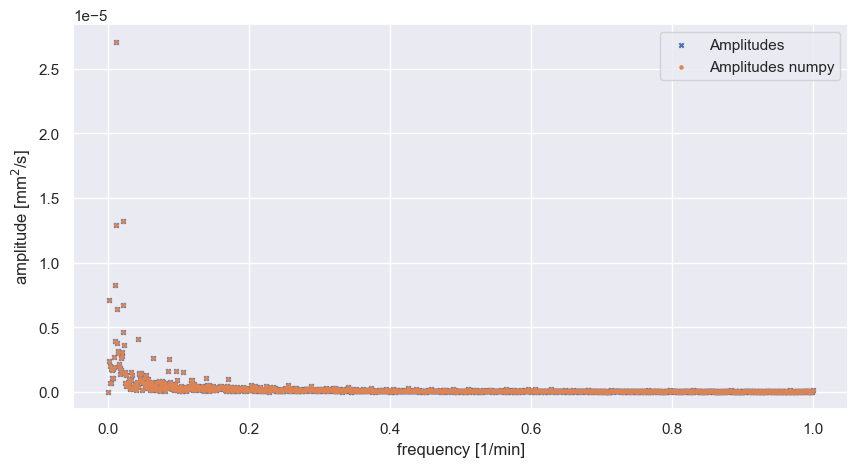

In [7]:
fourier_analize(data_sample['date'], data_sample['S_lin'], 30)
fourier_analize(data_sample['date'], data_sample['S_lin'], 120)
fourier_analize(data_sample['date'], data_sample['S_lin'], 720)
fourier_analize(data_sample['date'], data_sample['S_lin'], 1440)